# Project 2

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds fromeach disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [2]:
#import libraries:
import numpy as np 
#from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this
import cv2
import open3d as o3d
import os
from matplotlib import pyplot as plt
import random

In [2]:
### Script for storing the pcd in the mesh file 
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [3]:
## function given for reading txt files...replaced with another function 
def read_transformations(filename='poses.txt'):
    f = open(filename, 'r')
    lines = f.readlines()
    transformation_list = []
    for i in range(len(lines)):
        transformation_list_temp = lines[i].split()
        temp_rot = [] 
        temp_rot.append( (transformation_list_temp[0:4] ) ) 
        temp_rot.append( (transformation_list_temp[4:8]  ) ) 
        temp_rot.append( (transformation_list_temp[8:12]  ) ) 
        transformation_list.append(temp_rot)
    return transformation_list


In [4]:
###### getting data from text files

## --- Reading poses file----
def read_trans(filename='poses.txt'):
    f = open(filename, 'r')
    lines = f.readlines()
    transformation_list = []
    for i in range(len(lines)):
        transformation_list_temp = lines[i].split()
        temp_rot = [] 
        temp_rot.append( [float(transformation_list_temp[0]), float(transformation_list_temp[1]),float(transformation_list_temp[2]),float(transformation_list_temp[3])] ) 
        temp_rot.append( [float(transformation_list_temp[4]), float(transformation_list_temp[5]),float(transformation_list_temp[6]),float(transformation_list_temp[7])] ) 
        temp_rot.append( [float(transformation_list_temp[8]), float(transformation_list_temp[9]),float(transformation_list_temp[10]),float(transformation_list_temp[11])] ) 
        temp_rot.append([0,0,0,1])
        transformation_list.append(np.array(temp_rot))
    T = np.asarray(transformation_list)
    return T

## --- Reading calibration file----
def read_params(filename='calib.txt'):
    f = open(filename, 'r')
    lines = f.readlines()
    
    transformation_list_temp = lines[1].split()
    temp_rot = [] 
    temp_rot.append( [float(transformation_list_temp[0]), float(transformation_list_temp[1]),float(transformation_list_temp[2])] ) 
    temp_rot.append( [float(transformation_list_temp[3]), float(transformation_list_temp[4]),float(transformation_list_temp[5])] ) 
    temp_rot.append( [float(transformation_list_temp[6]), float(transformation_list_temp[7]),float(transformation_list_temp[8])] )
    K_list = np.asarray(temp_rot)
    transformation_list_temp = lines[4].split()
    B = float(transformation_list_temp[0]) 
    return K_list,B

Provide explanation in this cell: 


In [5]:

## 
ground_truth_file = './mr2020_project_data/poses.txt'
params_file = './mr2020_project_data/calib.txt'
trans = read_trans(ground_truth_file) ## ground truth values for poses  
K,B = read_params(params_file)     # getting itrinsic matrix and B (baseline)
focal_length = K[0][0]

# Images location
left_dir = './mr2020_project_data/img2/' 
right_dir = './mr2020_project_data/img3/'
img_name = sorted(os.listdir(left_dir))

In [6]:
## Main code starts here --- Run the cell to get global points and colors 
final_op = []  # final points array
final_col = [] # final colors array
end_pts = [0]
aaa = len(img_name)
#aaa = 1

#Running the loop
for counter in range(aaa):
        
        ## Reading images from respective directories
        left_img = cv2.imread(left_dir + img_name[counter])
        right_img = cv2.imread(right_dir + img_name[counter])
        
        # Setting parameters for the opencv function
        window_size = 5
        min_disp = -39
        num_disp = 144
        stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        disp12MaxDiff = 1,
        blockSize=5,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32,
        preFilterCap=63
        )
        
        ## Finding Disparity map using opencv inbuilt function
        disparity_map = stereo.compute(left_img,right_img).astype(np.float32) / 64.0
        disparity_map = (disparity_map-min_disp)/num_disp
        #print(disparity_map)
        h, w = disparity_map.shape
        
        #Storing colors of the scene 
        colors = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
        
        # Setting Q matrix 
        Q = np.asarray([[1, 0, 0, -0.5*w],[0,-1, 0,  0.5*h], [0, 0, 0, focal_length], [0, 0, 1/B,  0]]) # Useful for formulation rectification problem
        
        #Arranging Disparity map according to our convention
        points = []
        pt_set = []
        for i in range(h):
            for j in range(w):
                pt_set.append(np.array([j,i,disparity_map[i][j],1]))
        pt_set = np.array(pt_set)
        #print(pt_set)
        #print(pt_set[0].shape)
        
        #Obtaining 3D points from the Disparity map
        for pt in pt_set:
            point = Q@pt
            points.append(point/point[3])
        points = np.asarray(points) 
        #print(points)
        
        # Converting 3D points to Global frame using the Transformations given
        points = trans[counter]@points.T
        #print(points)
        #print(len(points[1]))
        
        #Applying Mask....other masks also can be performed to filter out the extra material in the 
        mask = disparity_map >= disparity_map.min()
        colors = colors[mask]
        colors = colors / 255
        #print(np.array(colors))
        print(counter+1, "image is done")
        
        # Storing the obtained points and colors in the final array
        for i in range(len(points[0])):
            if(points[3][i]>0):
                #print('yes')
                final_op.append([points[0][i]/points[3][i],points[1][i]/points[3][i],points[2][i]/points[3][i]])
                final_col.append(colors[i])
        end_pts.append(len(final_op))

1 image is done
2 image is done
3 image is done
4 image is done
5 image is done
6 image is done
7 image is done
8 image is done
9 image is done
10 image is done
11 image is done
12 image is done
13 image is done
14 image is done
15 image is done
16 image is done
17 image is done
18 image is done
19 image is done
20 image is done
21 image is done


In [7]:
final_op = np.asarray(final_op)
final_col = np.asarray(final_col)
final_op.T[0] *= -1

In [8]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(final_op)
pcd.colors = o3d.utility.Vector3dVector(final_col)
o3d.visualization.draw_geometries([pcd])

In [9]:
final_col1 = final_col*255
file_name = 'test.ply'
write_ply(file_name,final_op,final_col1)

In [29]:
print("Load a ply point cloud, print it, and render it")
pcd1 = o3d.io.read_point_cloud("./test.ply")
o3d.visualization.draw_geometries([pcd1])

Load a ply point cloud, print it, and render it


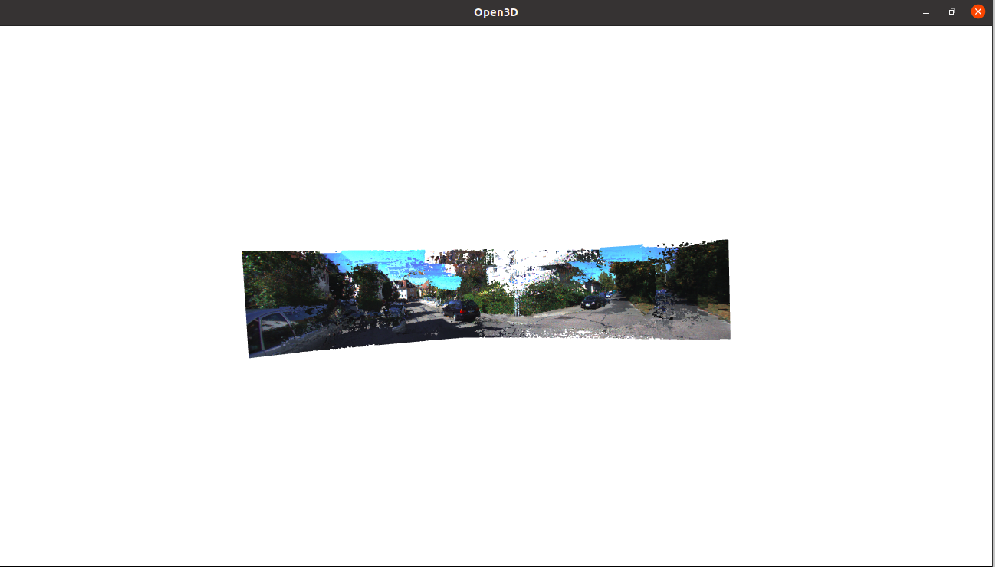

In [28]:
#print(np.asarray(pcd.points))
#print(final_op)
#print(h,w)
#print(np.array(pcd1.points))
#print(np.array(pcd.points))

[[ -552.473143   505.315899 -2331.439254]
 [ -550.042944   505.425885 -2330.336467]
 [ -547.612746   505.535871 -2329.233679]
 ...
 [  638.891976  -356.355551 -2430.531227]
 [  641.191342  -356.237835 -2431.885169]
 [  643.490708  -356.120119 -2433.239112]]
[[ -552.47314283   505.31589864 -2331.43925423]
 [ -550.04294438   505.42588476 -2330.33646653]
 [ -547.61274594   505.53587087 -2329.23367882]
 ...
 [  638.89197601  -356.35555097 -2430.53122661]
 [  641.19134213  -356.23783484 -2431.8851692 ]
 [  643.49070826  -356.12011872 -2433.23911179]]


----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

In [70]:
### getting 3D points from the point cloud 
#pcd = o3d.io.read_point_cloud("./test.ply")
final_op1 = np.array(pcd.points)

### getting the ground truth
"""
Q1 = np.array([ [-9.1e-01, 5.5e-02, -4.2e-01, -1.9e+02],
               [4.2e-02, 9.983072e-01, 4.2e-02, 1.7e+00],
               [4.2e-01, 2.1e-02, -9.2e-01, 5.5e+01],
              [0,0,0,1]])
Q1 = np.linalg.inv(trans[0])
"""
Q1 = np.array([ [-9.1e-01, 5.5e-02, -4.2e-01, -1.9e+02],
               [4.2e-02, 9.983072e-01, 4.2e-02, 1.7e+00],
               [4.2e-01, 2.1e-02, -9.2e-01, 5.5e+01],
              [0,0,0,1]])
Q1 = np.linalg.inv(Q1)
Q = Q1[:3,:]

P_gt = K@Q
#T = np.hstack((np.eye(3),[[0.04],[0.05],[0.06]]))
#P_gt = K @ T
#P_gt = P_gt/P_gt[-1,-1]
print(P_gt)

[[-8.88191631e+02  5.41139423e+01 -2.46276119e+02 -1.55303217e+05]
 [-3.62607430e+01  7.13441345e+02 -1.49909078e+02  1.42607815e+02]
 [-4.12056509e-01  4.15693433e-02 -8.96946037e-01 -2.90293725e+01]]


In [71]:
## indices can be changed
ind = range(0,10000)
#ind=random.sample(range(0,len(final_op)),10)
#print(ind[1])
#ind = range(0,10000)
#ind = range(0,40)
points_3d = []
points_2d = []
ones = np.ones((len(final_op1),1))
test = np.concatenate((final_op1,ones),axis = 1 ) 
proj = P_gt@(test.T)
proj = proj/proj[2,:]
proj = proj.T
#proj = proj/proj[2]
print(proj)

for i in ind:
    points_3d.append(test[i])
    points_2d.append(proj[i])
points_3d = np.array(points_3d)
points_2d = np.array(points_2d)

#print(points_3d)

[[405.45291228 315.99114663   1.        ]
 [404.75172509 316.18716573   1.        ]
 [404.0493306  316.38352233   1.        ]
 ...
 [-76.5976169   46.50187423   1.        ]
 [-77.49534249  46.60380227   1.        ]
 [-78.39280756  46.70570074   1.        ]]


In [72]:
### Initialising P: 1.Random 2.DLT ...
def DLT(x,X):
    M = [];
    zeros = np.zeros(4);
    L = len(X);
    for i in range(L):
        M.append(np.hstack((-X[i],np.hstack((zeros,x[i][0]*X[i])))));
        M.append(np.hstack((zeros,np.hstack((-X[i],x[i][1]*X[i])))));
    M = np.array(M).reshape(2*L,12);
    U,D,VT= np.linalg.svd(M);
    P = np.array(VT[-1]).reshape(3,4);
    P = P/P[-1,-1]
    return P/P[-1,-1]

#P_est = DLT(points_2d,points_3d);
print("The Matrix P is")
P_dlt = DLT(points_2d[0:5000],points_3d[0:5000])*P_gt[2,3]
print(P_dlt)

The Matrix P is
[[-8.88191631e+02  5.41139422e+01 -2.46276119e+02 -1.55303217e+05]
 [-3.62607430e+01  7.13441345e+02 -1.49909078e+02  1.42607815e+02]
 [-4.12056509e-01  4.15693434e-02 -8.96946037e-01 -2.90293725e+01]]


In [76]:
def opt_func(P_est,points_3d,points_2d,stp,tol):
## Iterations - Guass_Newton .... P_est need to be given 
    ite = 0
    check = 1
    #tol = 1e-4
    lr = 1  #0.01
    stopper = stp
    #stopper = 100
    while (check==1):
        jac = []
        points_est = []
        P_final = P_est

        ##Forming Jacobian
        for pt in points_3d:
            pp = P_final @ pt
            ##pp = pp/pp[2]
            j = [pt[0]/pp[2],pt[1]/pp[2],pt[2]/pp[2],pt[3]/pp[2],0,0,0,0,(-pp[0]*pt[0])/(pp[2]*pp[2]),-pp[0]*pt[1]/(pp[2]*pp[2]),-pp[0]*pt[2]/(pp[2]*pp[2]),-pp[0]*pt[3]/(pp[2]*pp[2])]
            jac.append(np.array(j))
            j = [0,0,0,0,pt[0]/(pp[2]),pt[1]/(pp[2]),pt[2]/(pp[2]),pt[3]/(pp[2]),-pp[1]*pt[0]/(pp[2]*pp[2]),-pp[1]*pt[1]/(pp[2]*pp[2]),-pp[1]*pt[2]/(pp[2]*pp[2]),-pp[1]*pt[3]/(pp[2]*pp[2])]
            jac.append(np.array(j))
            pp = pp/pp[2]
            points_est.append(pp.T)

        jac = np.array(jac)
        points_est = np.array(points_est)

        ## Residual 
        er = []
        for i in range(len(points_est)):
            er.append(points_2d[i][0]-points_est[i][0])
            er.append(points_2d[i][1]-points_est[i][1])
        er = np.array(er)
        er = er.reshape(2*len(points_est),1)
        gg = np.linalg.pinv(jac.T@jac)
        P_final = P_final.reshape(12,1)
        update = gg@(jac.T@er)
        P_est = P_final + lr*update

        ## calculating error
        up = P_est-P_final
        diff = np.sqrt(up.T@up)
        P_est = P_est.reshape(3,4)
        P_final = P_final.reshape(3,4)
        plzz = (er.T@er)

        ## checking the termination
        ite = ite + 1
        if(ite%10==0):
            print(ite,"iterations done")
        #np.linalg.norm(jac.T@er)
        if(np.linalg.norm(jac.T@er)<tol):
            print(ite,"iterations done")
            print("error in estimate"+ str(diff))
            check = 0
        if(ite>stopper):
            print(ite,"iterations done")
            print("error in estimate"+ str(diff))
            check = 0
    
    return P_final,plzz

### Initialising the algorithm with different values and comparing the outputs

In [77]:
####Initialising DLT output (best initialization)
P_final, plzz = opt_func(P_dlt,points_3d,points_2d,stp=100,tol=1e-4)
print(P_final)
print(P_gt)
print(plzz)

10 iterations done
20 iterations done
30 iterations done
40 iterations done
50 iterations done
60 iterations done
70 iterations done
80 iterations done
90 iterations done
100 iterations done
101 iterations done
error in esrimate[[5.56865602e-11]]
[[-8.88191631e+02  5.41139422e+01 -2.46276119e+02 -1.55303217e+05]
 [-3.62607430e+01  7.13441345e+02 -1.49909078e+02  1.42607815e+02]
 [-4.12056509e-01  4.15693433e-02 -8.96946037e-01 -2.90293725e+01]]
[[-8.88191631e+02  5.41139423e+01 -2.46276119e+02 -1.55303217e+05]
 [-3.62607430e+01  7.13441345e+02 -1.49909078e+02  1.42607815e+02]
 [-4.12056509e-01  4.15693433e-02 -8.96946037e-01 -2.90293725e+01]]
[[2.30616897e-11]]


In [79]:
## Initialisation converging at another local minima

P_est = np.array([[ 3.05963083e+01, -1.86410995e+00,  0.48368729e+00,  5.34986476e+03],
 [ 1.24910530e+00, -2.45765334e+01,  5.16404815e+00, -4.91253523e+00],
 [ 1.41944683e-02, -1.43197526e-03,  3.08978789e-02,  1.00000000e+00]])
P_final, plzz = opt_func(P_est,points_3d,points_2d,stp=100,tol=1e-4)
print(P_final)
print(P_gt)
print(plzz)

10 iterations done
20 iterations done
30 iterations done
40 iterations done
50 iterations done
60 iterations done
70 iterations done
80 iterations done
90 iterations done
100 iterations done
101 iterations done
error in esrimate[[1.14622079e-12]]
[[ 3.04225171e+01 -1.91126648e+00  5.65260442e-01  5.34986464e+03]
 [ 5.30338086e-01 -2.47715137e+01  5.50117372e+00 -4.91302498e+00]
 [ 1.58751667e-02 -1.60188285e-03  3.45587509e-02  1.12019548e+00]]
[[-8.88191631e+02  5.41139423e+01 -2.46276119e+02 -1.55303217e+05]
 [-3.62607430e+01  7.13441345e+02 -1.49909078e+02  1.42607815e+02]
 [-4.12056509e-01  4.15693433e-02 -8.96946037e-01 -2.90293725e+01]]
[[6.36962882e+08]]


In [78]:
## Far initialisation which won't converge to ground truth 
P_est = np.array([[-7.97699140e-04, -1.56731843e-03, -9.64602229e-04,  5.53706762e-02],
                 [-1.68118921e-04,  4.15993556e-03,  1.04888333e-03,  5.32315076e-02],
                 [-1.05955850e-04, -9.42056054e-04, -2.61847498e-04,  1.00000000e+00]])

P_final, plzz = opt_func(P_est,points_3d,points_2d,stp=100,tol=1e-4)
print(P_final)
print(P_gt)
print(plzz)

9 iterations done
error in esrimate[[2.53371997e+20]]
[[-3.39174868e+17 -1.51467226e+17 -7.52321992e+17  5.10454682e+15]
 [ 1.52924884e+17  1.07647237e+17  3.71339262e+17 -5.26923652e+15]
 [-9.68483886e+16  1.05677081e+17 -1.64990236e+17 -6.45834564e+17]]
[[-8.88191631e+02  5.41139423e+01 -2.46276119e+02 -1.55303217e+05]
 [-3.62607430e+01  7.13441345e+02 -1.49909078e+02  1.42607815e+02]
 [-4.12056509e-01  4.15693433e-02 -8.96946037e-01 -2.90293725e+01]]
[[1.58373533e+14]]


### Conclusion

1. Using DLT output as initialization gives us better results and converges faster.
2. If the initialization is close to a local maxima, the algorithm will converge to that minima and thus not obtain the optimal configuration.
3. A bad initialization may lead to no solution in less iterations.
4. Thus Iterative PnP is useful to recover the poses given the 3D-2D correspondences.

# Project 2 - Part B:

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: // - A camera often stores the timestamp of the image when it takes a picture. We can then iterate through the images and assign `camera_ind` according to the timestamp.
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: 1. To initialise the 3D points, we use the essential matrix, corresponding points and the camera matrix to traingulate the initial 3D points. 
    2. Thus, since we know which 2D points correspond to the initialzed 3D points. Thus, we can then assign the indices accordingly.
3. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-3 - Transformations: // 1. Yes, it would make a difference. This is because, when we translate or rotate, we do so with respect to a specified coordinate frame. Thus, after translating, the coordinate frame for rotating will be different for rotation. Similarly, if I rotate first and then translate, the coordinte frame would be different. Thus, the final position would be different.
4. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-4 - Jacobian: This is because, in our lecture notes, we assume that M is the number of images and N is the number of points per image. Thus, the total number of the points is 2MN (2D). However, in this case, the number of points are not constant per image. Thus, it is not a function of MN.
5. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 5.1 - Jacobian & Parameters: This is because, here, we consider the axis angle notation of the transformation matrix. Since the axis angle notation has 6 parameters and camera intrinsics have 9 parameters, we consider `n_cameras * 12`.
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 5.2 - Jacobian & Parameters:In the notes, we take 12*n_cam + 3*n_pts as the number of unknown parameters. Further, to calculate n_pts we use the forumla (n_imgs * n_pts_per_img)/avg_no_of_times_the point is seen. However, as explained in 5.1, we replace "12" with "9".  Also, there is no need to calculate n_pts as in the lecture notes due to fact that we are already provided with it.
6. `2 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.)
    - Ans 6 - Sparsity, Residual Vector & Jacobian:
    
    1. The above 6 lines of code fills populates a sparese jacobian in which we specify certain locations to have 1s and 0s.
    2. In the below code, in the theoretical setting, The space jacobian has a neat structure which we defined. However, that is not the case in practical settings.
    3. In the practical setting, we decide to set a value at an index to 1 depending on the dependant variables which are to be optimized (for eg, the camera parameters and the 3D points). Thus, the places where 1 is present will not be as structured as the previous case.
    4. Sparsifying the jacobian will also speed up the run time of the code.
    

In [4]:
camera_ind_exp = 10
m = camera_ind_exp * 2
B = np.zeros([m,16])
B_prac = np.zeros([m,16])
i = np.arange(camera_ind_exp)

# theoretical setting
B[2*i, np.array([0,0,0,0,0,  1,1,1,1,1])]=1
B[2*i + 1, np.array([0,0,0,0,0,  1,1,1,1,1])]=1
# practical setting
B_prac[2*i, np.array([0,2,5,6,2,  1,9,14,7,11])]=1
B_prac[2*i + 1, np.array([0,2,5,6,2,  1,9,14,7,11])]=1

print("The theoretical sparse matrix")
print(B)
print("The practical sparse jacobian")
print(B_prac)

The theoretical sparse matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers). A sample answer could be as follows:

**Ans 2:**

1. First, we do feature matching using the following function
    1.1 First we extract the keypoints from both the images using the `img1Keypoints, img2Descriptors = orb.detectAndCompute(img1,None)` method of the `cv2.ORB_create() ` class. Here, we input the two images to separate such functions and we also pass "None" to show that we are not passing any predefined features. We get the keypoints and descriptors corresponding to the two images.
    1.2 We then match the two keypoints from the two images using the `matches = matcher.match(img1Descriptors,img2Descriptors)` function of the `cv2.BFMatcher()`  class. We input the two feature descriptors of the two images obtained from the previous step and we get the matched features as the output. We can then use these "matches" to obtain the corresponding points in two images. We will store this as pts0 and pts1.

2. In order to obtain th essential matrix, we use the `E=cv2.findEssentialMat(pts0,pts1,K)`. Here, we input the corresponding points in the two images (pts0,pts1) and also the K matrix. We get the essential matrix E as the output.

3. Now that we have essential matrix, we can decompose it into R,t as following:

    `Rt = cv2.recoverPose(E, pts0, pts1, K)`: This takes Essential matrix, K matrix and the corresponding points in 2 images as input arguments and gives us R,t. `Rt[1]` would give us R and `Rt[2]` would give us t.

4. Now we will use triangulation to initialize the 3D poses. We will use the `points_3d = cv2.triangulatePoints([pts0,pts1],Rt)`. We input the corresponding points [pts0,pts1] and the Rt matrix obtained from the previous step. We get the 3D points as the output.


## Work Distribution

1. Rahul worked on the first question of part A and part B.
2. Avinash worked on the second question of part A and part B.
3. Both of us were on numerous video calls for coding and debugging sessions to keep each other company and help at the same time.